In [2]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os
import random

In [6]:
import os
import random

train_dir = '/Users/nishanth/Desktop/dl/BRAINTUMOR/archive (3)/Training'
test_dir = '/Users/nishanth/Desktop/dl/BRAINTUMOR/archive (3)/Testing'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

combined = list(zip(train_paths, train_labels))
random.shuffle(combined)
train_paths[:], train_labels[:] = zip(*combined)


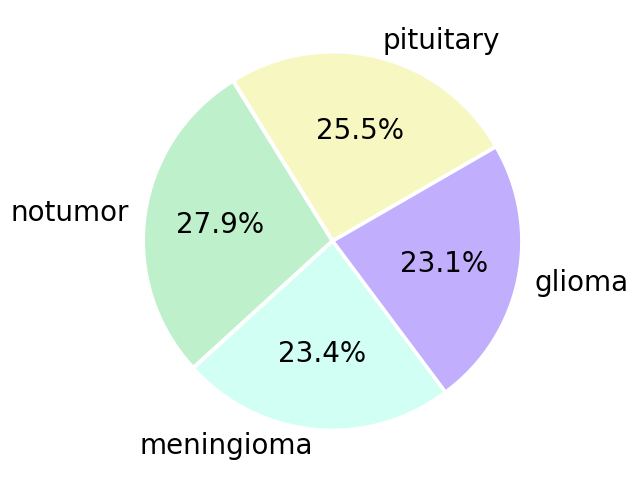

In [7]:
plt.figure(figsize=(14,6))
colors = ['#F6F7C1', '#BEF0CB', '#D1FFF3', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.015,0.015,0.015,0.015),
        startangle=30);

In [9]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

# Shuffle the test_paths and test_labels in the same order
combined = list(zip(test_paths, test_labels))
random.shuffle(combined)
test_paths[:], test_labels[:] = zip(*combined)

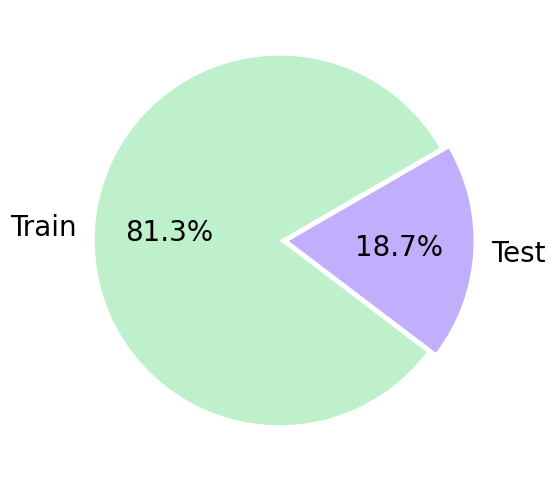

In [10]:
plt.figure(figsize=(14,6))
colors = ['#BEF0CB', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [11]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

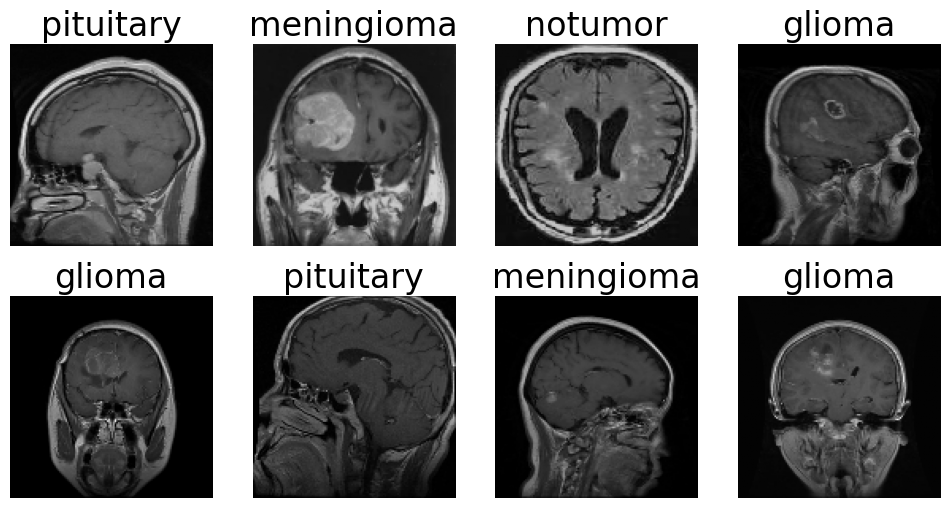

In [12]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [13]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels


In [14]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

58889256/58889256 [==============================] - 21s 0us/step


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15763908 (60.13 MB)
Trainable params: 8128

In [16]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [18]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
285/285 [==============================] - 447s 2s/step - loss: 0.4541 - sparse_categorical_accuracy: 0.8291
Epoch 2/10
285/285 [==============================] - 442s 2s/step - loss: 0.2259 - sparse_categorical_accuracy: 0.9171
Epoch 3/10
285/285 [==============================] - 484s 2s/step - loss: 0.1637 - sparse_categorical_accuracy: 0.9346
Epoch 4/10
285/285 [==============================] - 426s 1s/step - loss: 0.1201 - sparse_categorical_accuracy: 0.9547
Epoch 5/10
285/285 [==============================] - 425s 1s/step - loss: 0.0935 - sparse_categorical_accuracy: 0.9661
Epoch 6/10
285/285 [==============================] - 426s 1s/step - loss: 0.0643 - sparse_categorical_accuracy: 0.9761
Epoch 7/10
285/285 [==============================] - 442s 2s/step - loss: 0.0778 - sparse_categorical_accuracy: 0.9728
Epoch 8/10
285/285 [==============================] - 441s 2s/step - loss: 0.0415 - sparse_categorical_accuracy: 0.9842
Epoch 9/10
285/285 [====================

In [19]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds 
NUM_CLIENTS = 10
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())
 
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)
        

        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)

        
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)
model.save('my_model.h5')

Epoch 1/5
28/28 [==============================] - 46s 2s/step - loss: 0.0372 - sparse_categorical_accuracy: 0.9875
Epoch 2/5
28/28 [==============================] - 45s 2s/step - loss: 0.1029 - sparse_categorical_accuracy: 0.9819
Epoch 3/5
28/28 [==============================] - 45s 2s/step - loss: 0.0190 - sparse_categorical_accuracy: 0.9927
Epoch 4/5
28/28 [==============================] - 47s 2s/step - loss: 0.0143 - sparse_categorical_accuracy: 0.9927
Epoch 5/5
28/28 [==============================] - 46s 2s/step - loss: 0.0445 - sparse_categorical_accuracy: 0.9927


Epoch 1/5
28/28 [==============================] - 49s 2s/step - loss: 0.0141 - sparse_categorical_accuracy: 0.9982
Epoch 2/5
28/28 [==============================] - 46s 2s/step - loss: 0.0328 - sparse_categorical_accuracy: 0.9855
Epoch 3/5
28/28 [==============================] - 46s 2s/step - loss: 0.0132 - sparse_categorical_accuracy: 0.9946
Epoch 4/5
28/28 [==============================] - 42s 1s/step - loss: 0.0519 - sparse_categorical_accuracy: 0.9837
Epoch 5/5
28/28 [==============================] - 40s 1s/step - loss: 0.0316 - sparse_categorical_accuracy: 0.9909


Epoch 1/5
28/28 [==============================] - 45s 2s/step - loss: 0.0169 - sparse_categorical_accuracy: 0.9929
Epoch 2/5
28/28 [==============================] - 42s 2s/step - loss: 0.0299 - sparse_categorical_accuracy: 0.9873
Epoch 3/5
28/28 [==============================] - 44s 2s/step - loss: 0.0131 - sparse_categorical_accuracy: 0.9964
Epoch 4/5
28/28 [==============================] - 42s 2s/step - loss: 0.0392 - sparse_categorical_accuracy: 0.9891
Epoch 5/5
28/28 [==============================] - 41s 1s/step - loss: 0.0029 - sparse_categorical_accuracy: 1.0000


Epoch 1/5
28/28 [==============================] - 41s 1s/step - loss: 0.0410 - sparse_categorical_accuracy: 0.9875
Epoch 2/5
28/28 [==============================] - 41s 1s/step - loss: 0.0227 - sparse_categorical_accuracy: 0.9946
Epoch 3/5
28/28 [==============================] - 41s 1s/step - loss: 0.0347 - sparse_categorical_accuracy: 0.9891
Epoch 4/5
28/28 [==============================] - 40s 1s/step - loss: 0.0096 - sparse_categorical_accuracy: 0.9964
Epoch 5/5
28/28 [==============================] - 40s 1s/step - loss: 0.0101 - sparse_categorical_accuracy: 0.9964


Epoch 1/5
28/28 [==============================] - 41s 1s/step - loss: 0.0440 - sparse_categorical_accuracy: 0.9893
Epoch 2/5
28/28 [==============================] - 41s 2s/step - loss: 0.0290 - sparse_categorical_accuracy: 0.9909
Epoch 3/5
28/28 [==============================] - 40s 1s/step - loss: 0.0067 - sparse_categorical_accuracy: 0.9982
Epoch 4/5
28/28 [==============================] - 40s 1s/step - loss: 0.0073 - sparse_categorical_accuracy: 0.9964
Epoch 5/5
28/28 [==============================] - 40s 1s/step - loss: 0.0474 - sparse_categorical_accuracy: 0.9891


Epoch 1/5
28/28 [==============================] - 42s 1s/step - loss: 0.0337 - sparse_categorical_accuracy: 0.9893
Epoch 2/5
28/28 [==============================] - 40s 1s/step - loss: 0.0119 - sparse_categorical_accuracy: 0.9982
Epoch 3/5
28/28 [==============================] - 41s 1s/step - loss: 0.0294 - sparse_categorical_accuracy: 0.9909
Epoch 4/5
28/28 [==============================] - 40s 1s/step - loss: 0.0650 - sparse_categorical_accuracy: 0.9891
Epoch 5/5
28/28 [==============================] - 40s 1s/step - loss: 0.0081 - sparse_categorical_accuracy: 0.9946


Epoch 1/5
28/28 [==============================] - 40s 1s/step - loss: 0.0253 - sparse_categorical_accuracy: 0.9964
Epoch 2/5
28/28 [==============================] - 39s 1s/step - loss: 0.0597 - sparse_categorical_accuracy: 0.9891
Epoch 3/5
28/28 [==============================] - 39s 1s/step - loss: 0.0461 - sparse_categorical_accuracy: 0.9873
Epoch 4/5
28/28 [==============================] - 39s 1s/step - loss: 0.0342 - sparse_categorical_accuracy: 0.9909
Epoch 5/5
28/28 [==============================] - 40s 1s/step - loss: 0.0439 - sparse_categorical_accuracy: 0.9909


Epoch 1/5
28/28 [==============================] - 40s 1s/step - loss: 0.0355 - sparse_categorical_accuracy: 0.9821
Epoch 2/5
28/28 [==============================] - 41s 1s/step - loss: 0.0076 - sparse_categorical_accuracy: 0.9982
Epoch 3/5
28/28 [==============================] - 40s 1s/step - loss: 0.0380 - sparse_categorical_accuracy: 0.9927
Epoch 4/5
28/28 [==============================] - 39s 1s/step - loss: 0.0099 - sparse_categorical_accuracy: 0.9964
Epoch 5/5
28/28 [==============================] - 39s 1s/step - loss: 0.0521 - sparse_categorical_accuracy: 0.9873


Epoch 1/5
28/28 [==============================] - 40s 1s/step - loss: 0.0421 - sparse_categorical_accuracy: 0.9875
Epoch 2/5
28/28 [==============================] - 40s 1s/step - loss: 0.0106 - sparse_categorical_accuracy: 0.9964
Epoch 3/5
28/28 [==============================] - 40s 1s/step - loss: 0.0220 - sparse_categorical_accuracy: 0.9909
Epoch 4/5
28/28 [==============================] - 39s 1s/step - loss: 0.0117 - sparse_categorical_accuracy: 0.9946
Epoch 5/5
28/28 [==============================] - 39s 1s/step - loss: 0.0423 - sparse_categorical_accuracy: 0.9946


Epoch 1/5
28/28 [==============================] - 40s 1s/step - loss: 0.0015 - sparse_categorical_accuracy: 1.0000
Epoch 2/5
28/28 [==============================] - 39s 1s/step - loss: 0.0353 - sparse_categorical_accuracy: 0.9909
Epoch 3/5
28/28 [==============================] - 40s 1s/step - loss: 0.0465 - sparse_categorical_accuracy: 0.9873
Epoch 4/5
28/28 [==============================] - 40s 1s/step - loss: 0.0430 - sparse_categorical_accuracy: 0.9837
Epoch 5/5
28/28 [==============================] - 39s 1s/step - loss: 0.0650 - sparse_categorical_accuracy: 0.9782


Epoch 1/5
28/28 [==============================] - 40s 1s/step - loss: 0.0127 - sparse_categorical_accuracy: 0.9964
Epoch 2/5
28/28 [==============================] - 39s 1s/step - loss: 0.0922 - sparse_categorical_accuracy: 0.9873
Epoch 3/5
28/28 [==============================] - 39s 1s/step - loss: 0.0273 - sparse_categorical_accuracy: 0.9927
Epoch 4/5
28/28 [==============================] - 39s 1s/step - loss: 0.0040 - sparse_categorical_accuracy: 0.9982
Epoch 5/5
28/28 [==============================] - 39s 1s/step - loss: 6.5105e-04 - sparse_categorical_accuracy: 1.0000


Epoch 1/5
28/28 [==============================] - 40s 1s/step - loss: 0.0236 - sparse_categorical_accuracy: 0.9929
Epoch 2/5
28/28 [==============================] - 39s 1s/step - loss: 0.0399 - sparse_categorical_accuracy: 0.9891
Epoch 3/5
28/28 [==============================] - 39s 1s/step - loss: 0.0145 - sparse_categorical_accuracy: 0.9909
Epoch 4/5
28/28 [==============================] - 39s 1s/step - loss: 0.0146 - sparse_categorical_accuracy: 0.9946
Epoch 5/5
28/28 [==============================] - 39s 1s/step - loss: 0.0396 - sparse_categorical_accuracy: 0.9891


Epoch 1/5
28/28 [==============================] - 40s 1s/step - loss: 0.0420 - sparse_categorical_accuracy: 0.9911
Epoch 2/5
28/28 [==============================] - 39s 1s/step - loss: 0.0578 - sparse_categorical_accuracy: 0.9855
Epoch 3/5
28/28 [==============================] - 39s 1s/step - loss: 0.0076 - sparse_categorical_accuracy: 0.9964
Epoch 4/5
28/28 [==============================] - 39s 1s/step - loss: 6.5242e-04 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
28/28 [==============================] - 39s 1s/step - loss: 1.2048e-04 - sparse_categorical_accuracy: 1.0000


Epoch 1/5
28/28 [==============================] - 40s 1s/step - loss: 0.0030 - sparse_categorical_accuracy: 0.9982
Epoch 2/5
28/28 [==============================] - 39s 1s/step - loss: 0.1344 - sparse_categorical_accuracy: 0.9800
Epoch 3/5
28/28 [==============================] - 39s 1s/step - loss: 0.0217 - sparse_categorical_accuracy: 0.9909
Epoch 4/5
28/28 [==============================] - 39s 1s/step - loss: 0.0018 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
28/28 [==============================] - 40s 1s/step - loss: 0.0184 - sparse_categorical_accuracy: 0.9964


Epoch 1/5
28/28 [==============================] - 40s 1s/step - loss: 0.0565 - sparse_categorical_accuracy: 0.9929
Epoch 2/5
28/28 [==============================] - 39s 1s/step - loss: 0.0354 - sparse_categorical_accuracy: 0.9855
Epoch 3/5
28/28 [==============================] - 39s 1s/step - loss: 0.0241 - sparse_categorical_accuracy: 0.9891
Epoch 4/5
28/28 [==============================] - 39s 1s/step - loss: 0.0172 - sparse_categorical_accuracy: 0.9927
Epoch 5/5
28/28 [==============================] - 39s 1s/step - loss: 0.0466 - sparse_categorical_accuracy: 0.9855


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  2%|▎         | 1/40 [00:01<01:16,  1.97s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 2/40 [00:04<01:16,  2.01s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 3/40 [00:05<01:13,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 4/40 [00:07<01:12,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▎        | 5/40 [00:09<01:09,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 6/40 [00:11<01:07,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 7/40 [00:13<01:05,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 8/40 [00:15<01:03,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▎       | 9/40 [00:17<01:01,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 10/40 [00:19<00:59,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 11/40 [00:21<00:57,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 12/40 [00:23<00:55,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▎      | 13/40 [00:25<00:53,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 14/40 [00:27<00:51,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 15/40 [00:29<00:49,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 16/40 [00:31<00:47,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▎     | 17/40 [00:33<00:45,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 18/40 [00:35<00:43,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 19/40 [00:37<00:41,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 20/40 [00:39<00:39,  1.98s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▎    | 21/40 [00:41<00:37,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 22/40 [00:43<00:35,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▊    | 23/40 [00:45<00:33,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 24/40 [00:47<00:31,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▎   | 25/40 [00:49<00:29,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 26/40 [00:51<00:28,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 27/40 [00:53<00:25,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 28/40 [00:55<00:23,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▎  | 29/40 [00:57<00:21,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 30/40 [00:59<00:20,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 31/40 [01:01<00:18,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 32/40 [01:03<00:16,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▎ | 33/40 [01:05<00:14,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 34/40 [01:07<00:12,  2.01s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 35/40 [01:09<00:10,  2.02s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 36/40 [01:11<00:08,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▎| 37/40 [01:13<00:05,  2.00s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 38/40 [01:15<00:03,  1.99s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 39/40 [01:17<00:01,  1.99s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 40/40 [01:19<00:00,  1.99s/it]

1/1 [==============================] - 2s 2s/step


41it [01:21,  2.00s/it]                        
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.95      0.97      0.96       300
  meningioma       0.97      0.92      0.94       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



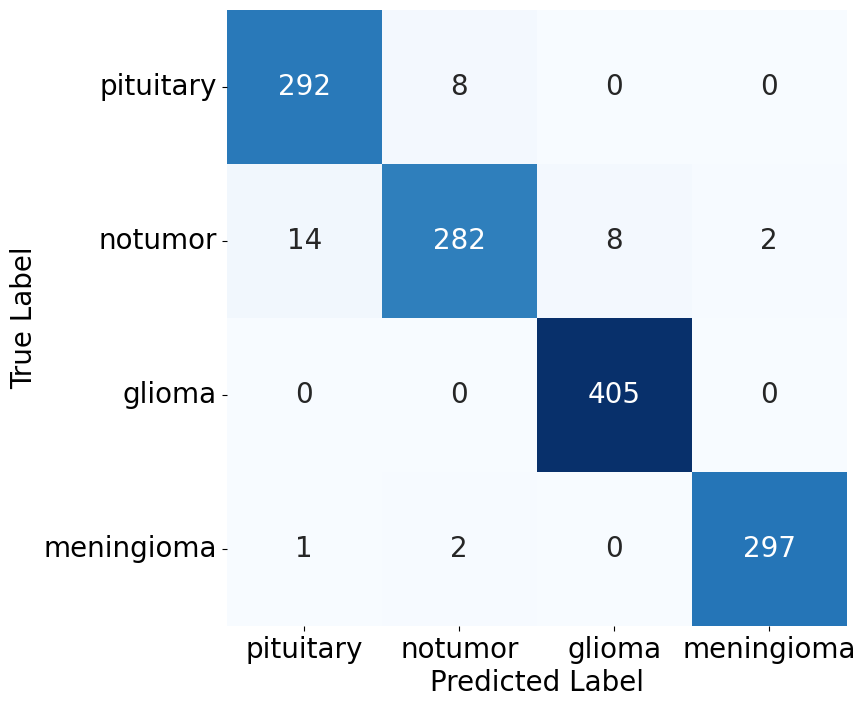

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




cm = confusion_matrix(y_true, y_pred)

font_size = 20

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()

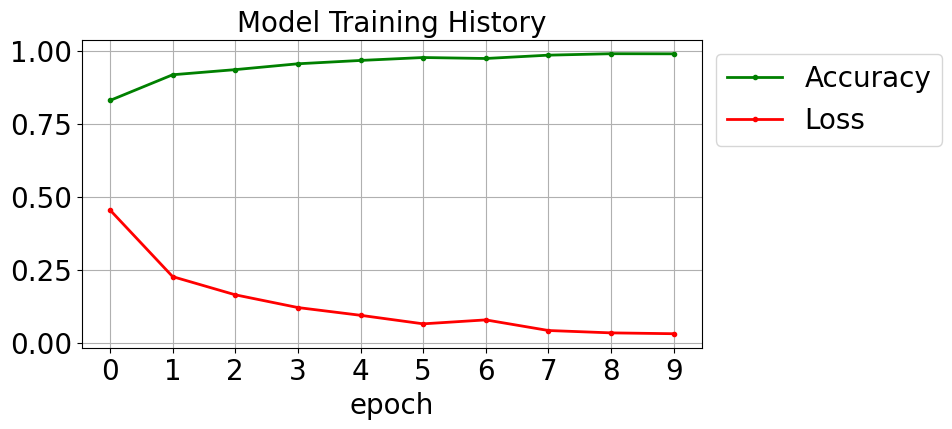

In [24]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History',fontsize =20)
plt.xlabel('epoch', fontsize =20)
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1), fontsize =20)
plt.show()